In [1]:
import os
import re
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [14]:
primer_path = '/Users/6j9/projects/sars_cov2-geospatial/data/primers/artic_v3.tsv'
data_dir = '/Users/6j9/projects/sars_cov2-geospatial/data/nucleotide_counts'
plot_dir = '/Users/6j9/projects/sars_cov2-geospatial/data/qual'

In [7]:
count_names = []
for r, d, f in os.walk(data_dir):
    for tsv in f:
        if re.search('.tsv$', tsv):
            count_names.append(os.path.join(r, tsv))

for i, count_file in enumerate(count_names):
    if i == 0:
        count_sums = pd.read_csv(count_file, sep='\t', index_col=0, header=0)
    else:
        counts = pd.read_csv(count_file, sep='\t', index_col=0, header=0)
        count_sums += counts

In [11]:
count_sums

,a,c,g,t,u,r,y,k,m,s,w,b,d,h,v,n,-
0,289805,8221,206475,346374,41,133,147,145,27,36,404,19,22,27,11,70587,8154926
1,253871,586229,8973,549538,81,34,90,63,44,91,322,8,10,51,78,72673,7605244
2,887289,341602,324650,175955,24,94,64,53,114,36,172,2,5,23,68,80584,7266665
3,1443565,1455977,365,3814,0,215,157,1,74,23,136,3,7,262,0,54137,6118664
4,398101,1215065,394129,1973407,125,6,98,50,19,4,23,0,0,2,1,32514,5063856
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2996,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2997,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2998,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [8]:
def totals():
    count_sums.columns = ['counts']
    count_sums = count_sums.sort_values(by=['counts'], ascending=False)
    fig, ax = plt.subplots(figsize=(12, 8))
    x = np.arange(count_sums.shape[0])
    ax.bar(x, count_sums.iloc[:, 0])
    ax.set_xticks(x)
    ax.set_xticklabels(count_sums.index.values)
    ax.set_xlabel('Nucleotide Code')
    ax.set_ylabel('(log) Count')
    ax.set_yscale('log')
    ax.set_title('Totals Across all Sequences')
    plt.savefig(os.path.join(plot_dir, 'total_counts.png'))

In [9]:
def get_primer_locs(path, bin_size):
    primers = pd.read_csv(path, sep='\t', header=None, index_col=None)
    forward_right = primers.iloc[::2, 2]
    reverse_left = primers.iloc[1::2, 1]
    return forward_right.values, reverse_left.values

In [38]:
def generate_per_nt_code_bar_plots(count_sums, bin_size, start=0, end=30000, primers=None, large=False):
    for i in range(count_sums.shape[1]):
        title = count_sums.columns[i].upper()
        # restrict to deletions
        if title != '-': continue
        out_path = os.path.join(plot_dir, 'log_binned-' + title + f'-counts_bin-size-10_{start}-to-{end}-pos.png')
        start = int(start / bin_size)
        end = int(end / bin_size)
        fig, ax = plt.subplots(figsize=(16, 8))
        # x axis
        x = np.arange(count_sums.shape[0])[start : end]
        bar = ax.bar(x, count_sums.iloc[:, i].values[start : end], width=1, align='edge')
        xticks = np.linspace(start, end, (end - start) // 5 + 1)
        #xticks = np.linspace(start, end, 
        if not large:
            xticklabels = [str(int(xticks[i] * bin_size)) for i in range(len(xticks))]
            ax.set_xlabel('Genome Position', size=24)
        else:
            xticklabels = [str(round(xticks[i] / 100, 2)) for i in range(len(xticks))]
            ax.set_xlabel('Genome Position (thousands)', size=24)
        ax.set_xticks(xticks)
        ax.set_xticklabels(xticklabels, size=20)
        # y axis
        ax.set_ylabel('(log) Deletion Count', size=24)
        ax.set_yscale('log')
        ax.set_yticks(np.logspace(2, 7, 6))
        ax.set_yticklabels([f'$10^{j}$' for j in range(2, 8)], size=20)
        # other
        #ax.grid(which='both', axis='y')
        #ax.set_title(f'Binned Total for {title} Across all Sequences: {start * bin_size}bp to {end * bin_size}bp', size=20)
        ax.set_title('Deletions and Artic Primers', size=28)
        if primers:
            for_locs, rev_locs = get_primer_locs(primers, 10)
            for j in range(len(for_locs)):
                if for_locs[j] > start * bin_size and for_locs[j] < end * bin_size:
                    bar[for_locs[j] // bin_size - start].set_color(u'#2ca02c')
                if rev_locs[j] > start * bin_size and rev_locs[j] < end * bin_size:
                    bar[rev_locs[j] // bin_size - start].set_color(u'#d62728')
        out_path = os.path.join(plot_dir, 'log_binned-' + title + f'-counts_bin-size-10_{start}-{end}.png')
        plt.tight_layout()
        plt.savefig(out_path, dpi=300)
        plt.show()
        plt.clf()

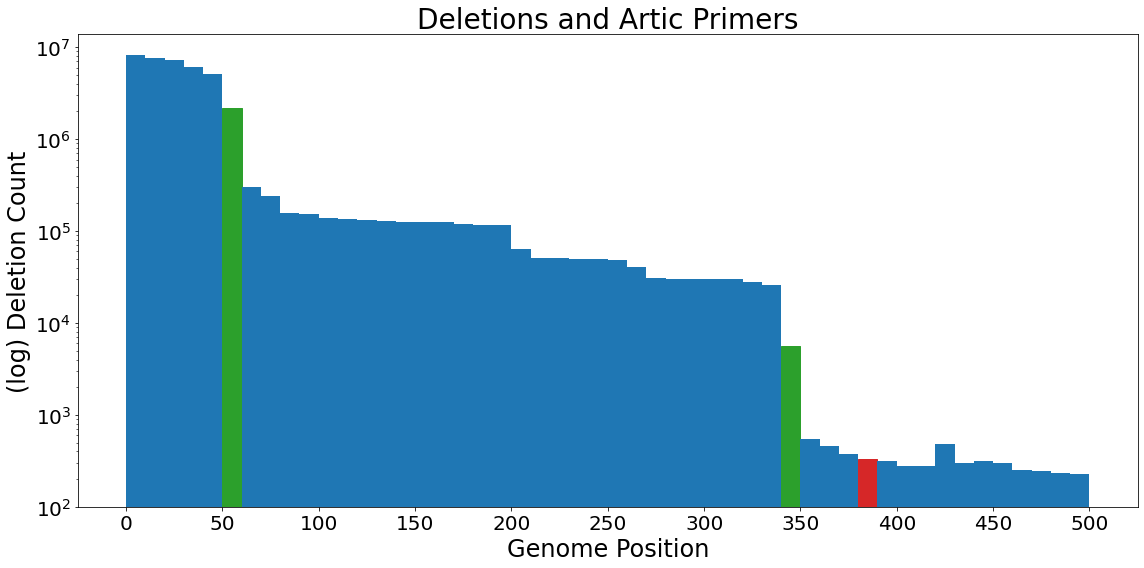

<Figure size 432x288 with 0 Axes>

In [39]:
# bin_size corresponds to the size of the resolution of the bins of count_sums
# start and end correspond to actual positions in the genome (no bins)
start = 0
end = 500
generate_per_nt_code_bar_plots(count_sums, bin_size=10,
                               start=start, end=end, primers=primer_path)

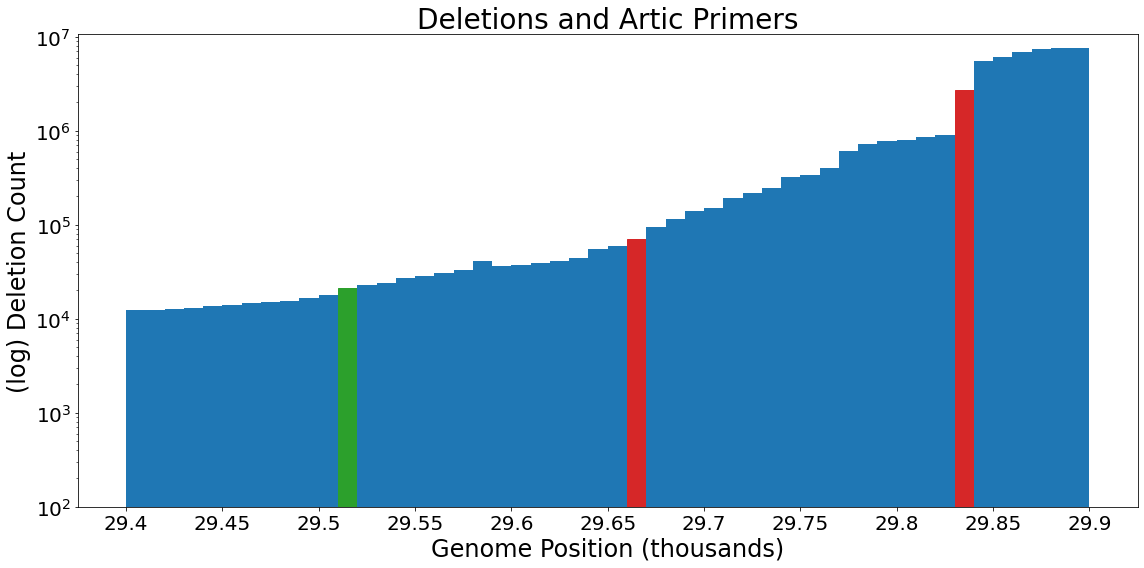

<Figure size 432x288 with 0 Axes>

In [40]:
start = 29400
end = 29900
generate_per_nt_code_bar_plots(count_sums, bin_size=10,
                               start=start, end=end, primers=primer_path, large=True)